In [1]:
import awkward as ak
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.colors import LogNorm
import matplotlib as mpl 
mpl.rcParams["image.origin"] = 'lower'
mpl.rcParams["image.cmap"] = "Blues"
mpl.rcParams["figure.dpi"] = 100

import h5py
import os
import numpy as np
from glob import glob
from math import ceil

import mplhep as hep
plt.style.use(hep.style.CMS)

ModuleNotFoundError: No module named 'mplhep'

In [2]:
inputdir_ele = "/work/dvalsecc/Clustering/dataset/electrons_awkward_2022v7/"
inputdir_gamma = "/work/dvalsecc/Clustering/dataset/gammas_awkward_2022v7/"
cols = ["cl_features", "cl_labels", "window_features", "window_metadata", "cl_h"]
df_ele = ak.from_parquet(inputdir_ele, lazy=True, use_threads=True, columns=cols)
df_gamma = ak.from_parquet(inputdir_gamma, lazy=True, use_threads=True, columns=cols)

df = ak.concatenate([df_ele, df_gamma])

# Dataset studies

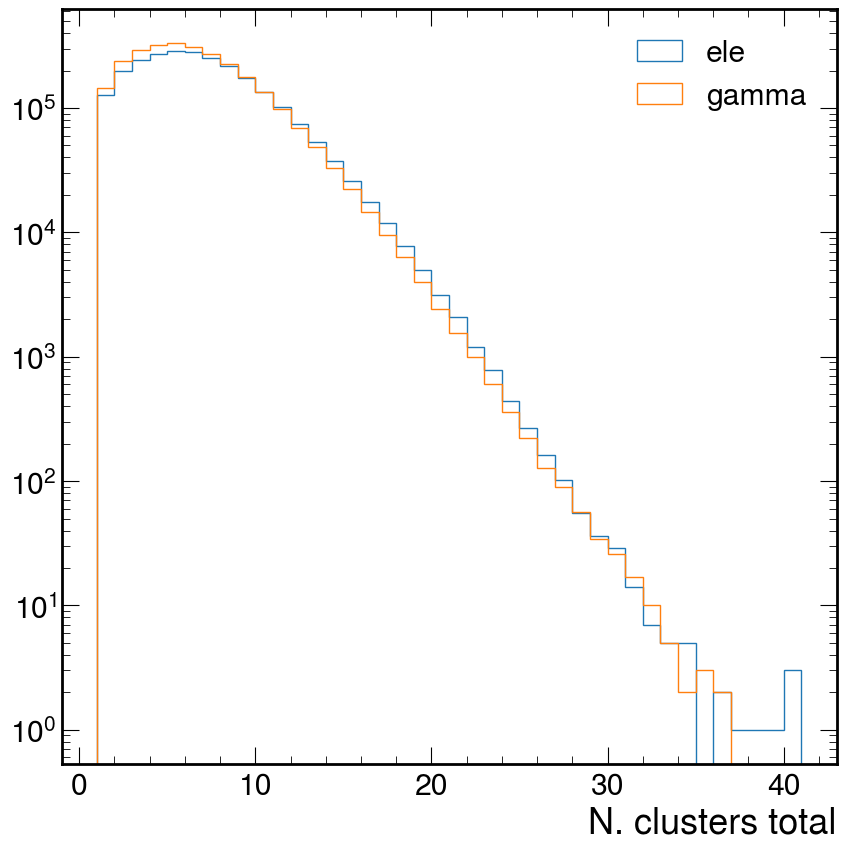

In [8]:
plt.hist(ak.num(df_ele.cl_features, axis=1), bins=40, range=(1, 41), histtype="step", label="ele")
plt.hist(ak.num(df_gamma.cl_features, axis=1), bins=40, range=(1, 41), histtype="step", label="gamma")
plt.yscale("log")
plt.xlabel("N. clusters total")
plt.legend()

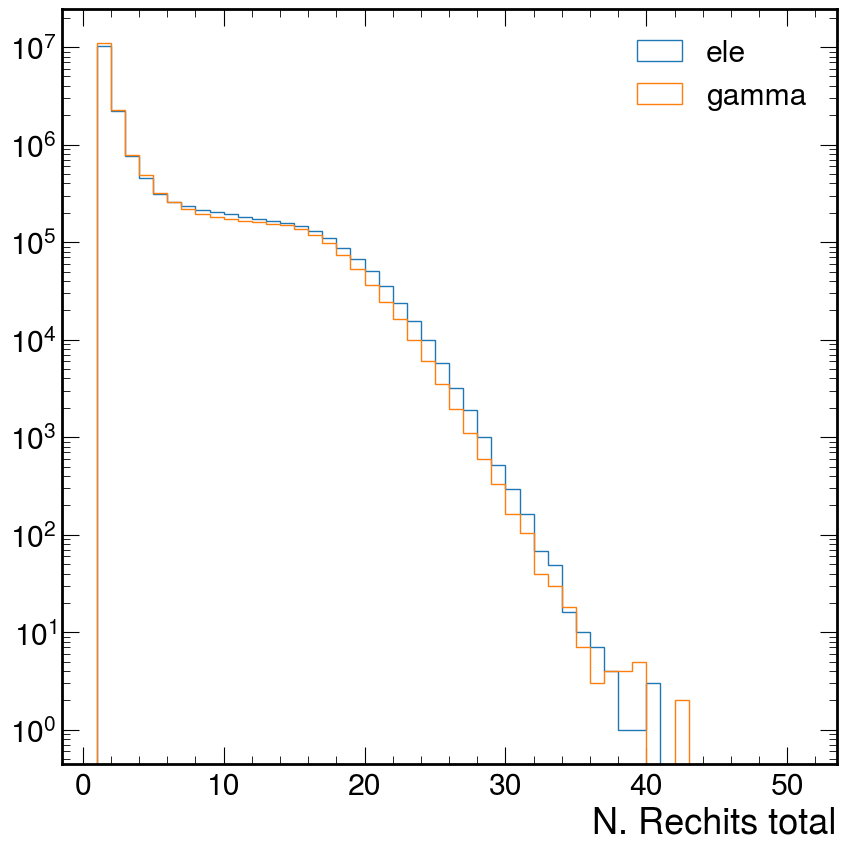

In [9]:
plt.hist(ak.flatten(ak.num(df_ele.cl_h, axis=2)), bins=50, range=(1, 51), histtype="step", label="ele")
plt.hist(ak.flatten(ak.num(df_gamma.cl_h, axis=2)), bins=50, range=(1, 51), histtype="step", label="gamma")
plt.yscale("log")
plt.xlabel("N. Rechits total")
plt.legend()

In [7]:
def plot_window_rechits(df):
    d = 5
    xmin = ak.min(df[:,:,1])-d
    xmax = ak.max(df[:,:,1])+d
    ymin = ak.min(df[:,:,0])-d
    ymax = ak.max(df[:,:,0])+d
    plt.hist2d(ak.flatten(df[:,:,1]), ak.flatten(df[:,:,0]), weights=ak.flatten(df[:,:,3]), range=((xmin, xmax), (ymin, ymax)), bins=(int(xmax-xmin), int(ymax-ymin)), norm=LogNorm(), cmap="viridis")
    plt.ylabel("ieta")
    plt.xlabel("iphi")
    plt.colorbar(label="Rechit Energy [GeV]")
    plt.show()

# Feature normalization

In [3]:
default_features_dict = {
        "cl_features" : [ "en_cluster","et_cluster",
                        "cluster_eta", "cluster_phi", 
                        "cluster_ieta","cluster_iphi","cluster_iz",
                        "cluster_deta", "cluster_dphi",
                        "cluster_den_seed","cluster_det_seed",
                        "en_cluster_calib", "et_cluster_calib",
                        "cl_f5_r9", "cl_f5_sigmaIetaIeta", "cl_f5_sigmaIetaIphi",
                        "cl_f5_sigmaIphiIphi","cl_f5_swissCross",
                        "cl_r9", "cl_sigmaIetaIeta", "cl_sigmaIetaIphi",
                        "cl_sigmaIphiIphi","cl_swissCross",
                        "cl_nxtals", "cl_etaWidth","cl_phiWidth"],


    "cl_metadata": [ "calo_score", "calo_simen_sig", "calo_simen_PU",
                     "cluster_PUfrac","calo_nxtals_PU",
                     "noise_en","noise_en_uncal","noise_en_nofrac","noise_en_uncal_nofrac" ],

    "cl_labels" : ["is_seed","is_calo_matched","is_calo_seed", "in_scluster","in_geom_mustache","in_mustache"],

    
    "seed_features" : ["seed_eta","seed_phi", "seed_ieta","seed_iphi", "seed_iz", 
                     "en_seed", "et_seed","en_seed_calib","et_seed_calib",
                    "seed_f5_r9","seed_f5_sigmaIetaIeta", "seed_f5_sigmaIetaIphi",
                    "seed_f5_sigmaIphiIphi","seed_f5_swissCross",
                    "seed_r9","seed_sigmaIetaIeta", "seed_sigmaIetaIphi",
                    "seed_sigmaIphiIphi","seed_swissCross",
                    "seed_nxtals","seed_etaWidth","seed_phiWidth"
                    ],

    "seed_metadata": [ "seed_score", "seed_simen_sig", "seed_simen_PU", "seed_PUfrac"],
    "seed_labels" : [ "is_seed_calo_matched", "is_seed_calo_seed", "is_seed_mustache_matched"],

     "window_features" : [ "max_en_cluster","max_et_cluster","max_deta_cluster","max_dphi_cluster","max_den_cluster","max_det_cluster",
                         "min_en_cluster","min_et_cluster","min_deta_cluster","min_dphi_cluster","min_den_cluster","min_det_cluster",
                         "mean_en_cluster","mean_et_cluster","mean_deta_cluster","mean_dphi_cluster","mean_den_cluster","mean_det_cluster" ],

    "window_metadata": ["flavour", "ncls", "nclusters_insc",
                        "nVtx", "rho", "obsPU", "truePU",
                        "sim_true_eta", "sim_true_phi",  
                        "gen_true_eta","gen_true_phi",
                        "en_true_sim","et_true_sim", "en_true_gen", "et_true_gen",
                        "en_true_sim_good", "et_true_sim_good",
                        "en_mustache_raw", "et_mustache_raw","en_mustache_calib", "et_mustache_calib",
                        "max_en_cluster_insc","max_deta_cluster_insc","max_dphi_cluster_insc",
                        "event_tot_simen_PU","wtot_simen_PU","wtot_simen_sig" ],
}

In [4]:
stats = {}

for cl_f in default_features_dict["cl_features"]:
    m = ak.mean(df.cl_features[cl_f])
    s = ak.std(df.cl_features[cl_f])
    mmin = ak.min(df.cl_features[cl_f])
    mmax = ak.max(df.cl_features[cl_f])
    stats[cl_f] = { "mean": m, "std":s, "min": mmin, "max": mmax}
    print(f"Feature: {cl_f}, mean: {m}, std: {s}")

Feature: en_cluster, mean: 18.714986362798808, std: 68.8664470129998
Feature: et_cluster, mean: 5.909916714460881, std: 17.033740098202017
Feature: cluster_eta, mean: -0.004100051354079167, std: 1.5273451547101924
Feature: cluster_phi, mean: -0.009830379139120719, std: 1.8074419151593701
Feature: cluster_ieta, mean: 19.04049245068605, std: 49.700399825268526
Feature: cluster_iphi, mean: 132.40626834562497, std: 104.6639223872611
Feature: cluster_iz, mean: -0.0014407995480149591, std: 0.6094611297169836
Feature: cluster_deta, mean: 0.02210586097234891, std: 0.07891912373074293
Feature: cluster_dphi, mean: -0.00020582963953030736, std: 0.3255551426782348
Feature: cluster_den_seed, mean: 68.84715530796396, std: 101.5571335762913
Feature: cluster_det_seed, mean: 27.681857031142165, std: 29.933692982402345
Feature: en_cluster_calib, mean: 20.32811272728474, std: 74.31817626267252
Feature: et_cluster_calib, mean: 6.334744230788875, std: 17.776987884507744
Feature: cl_f5_r9, mean: 2.258529852

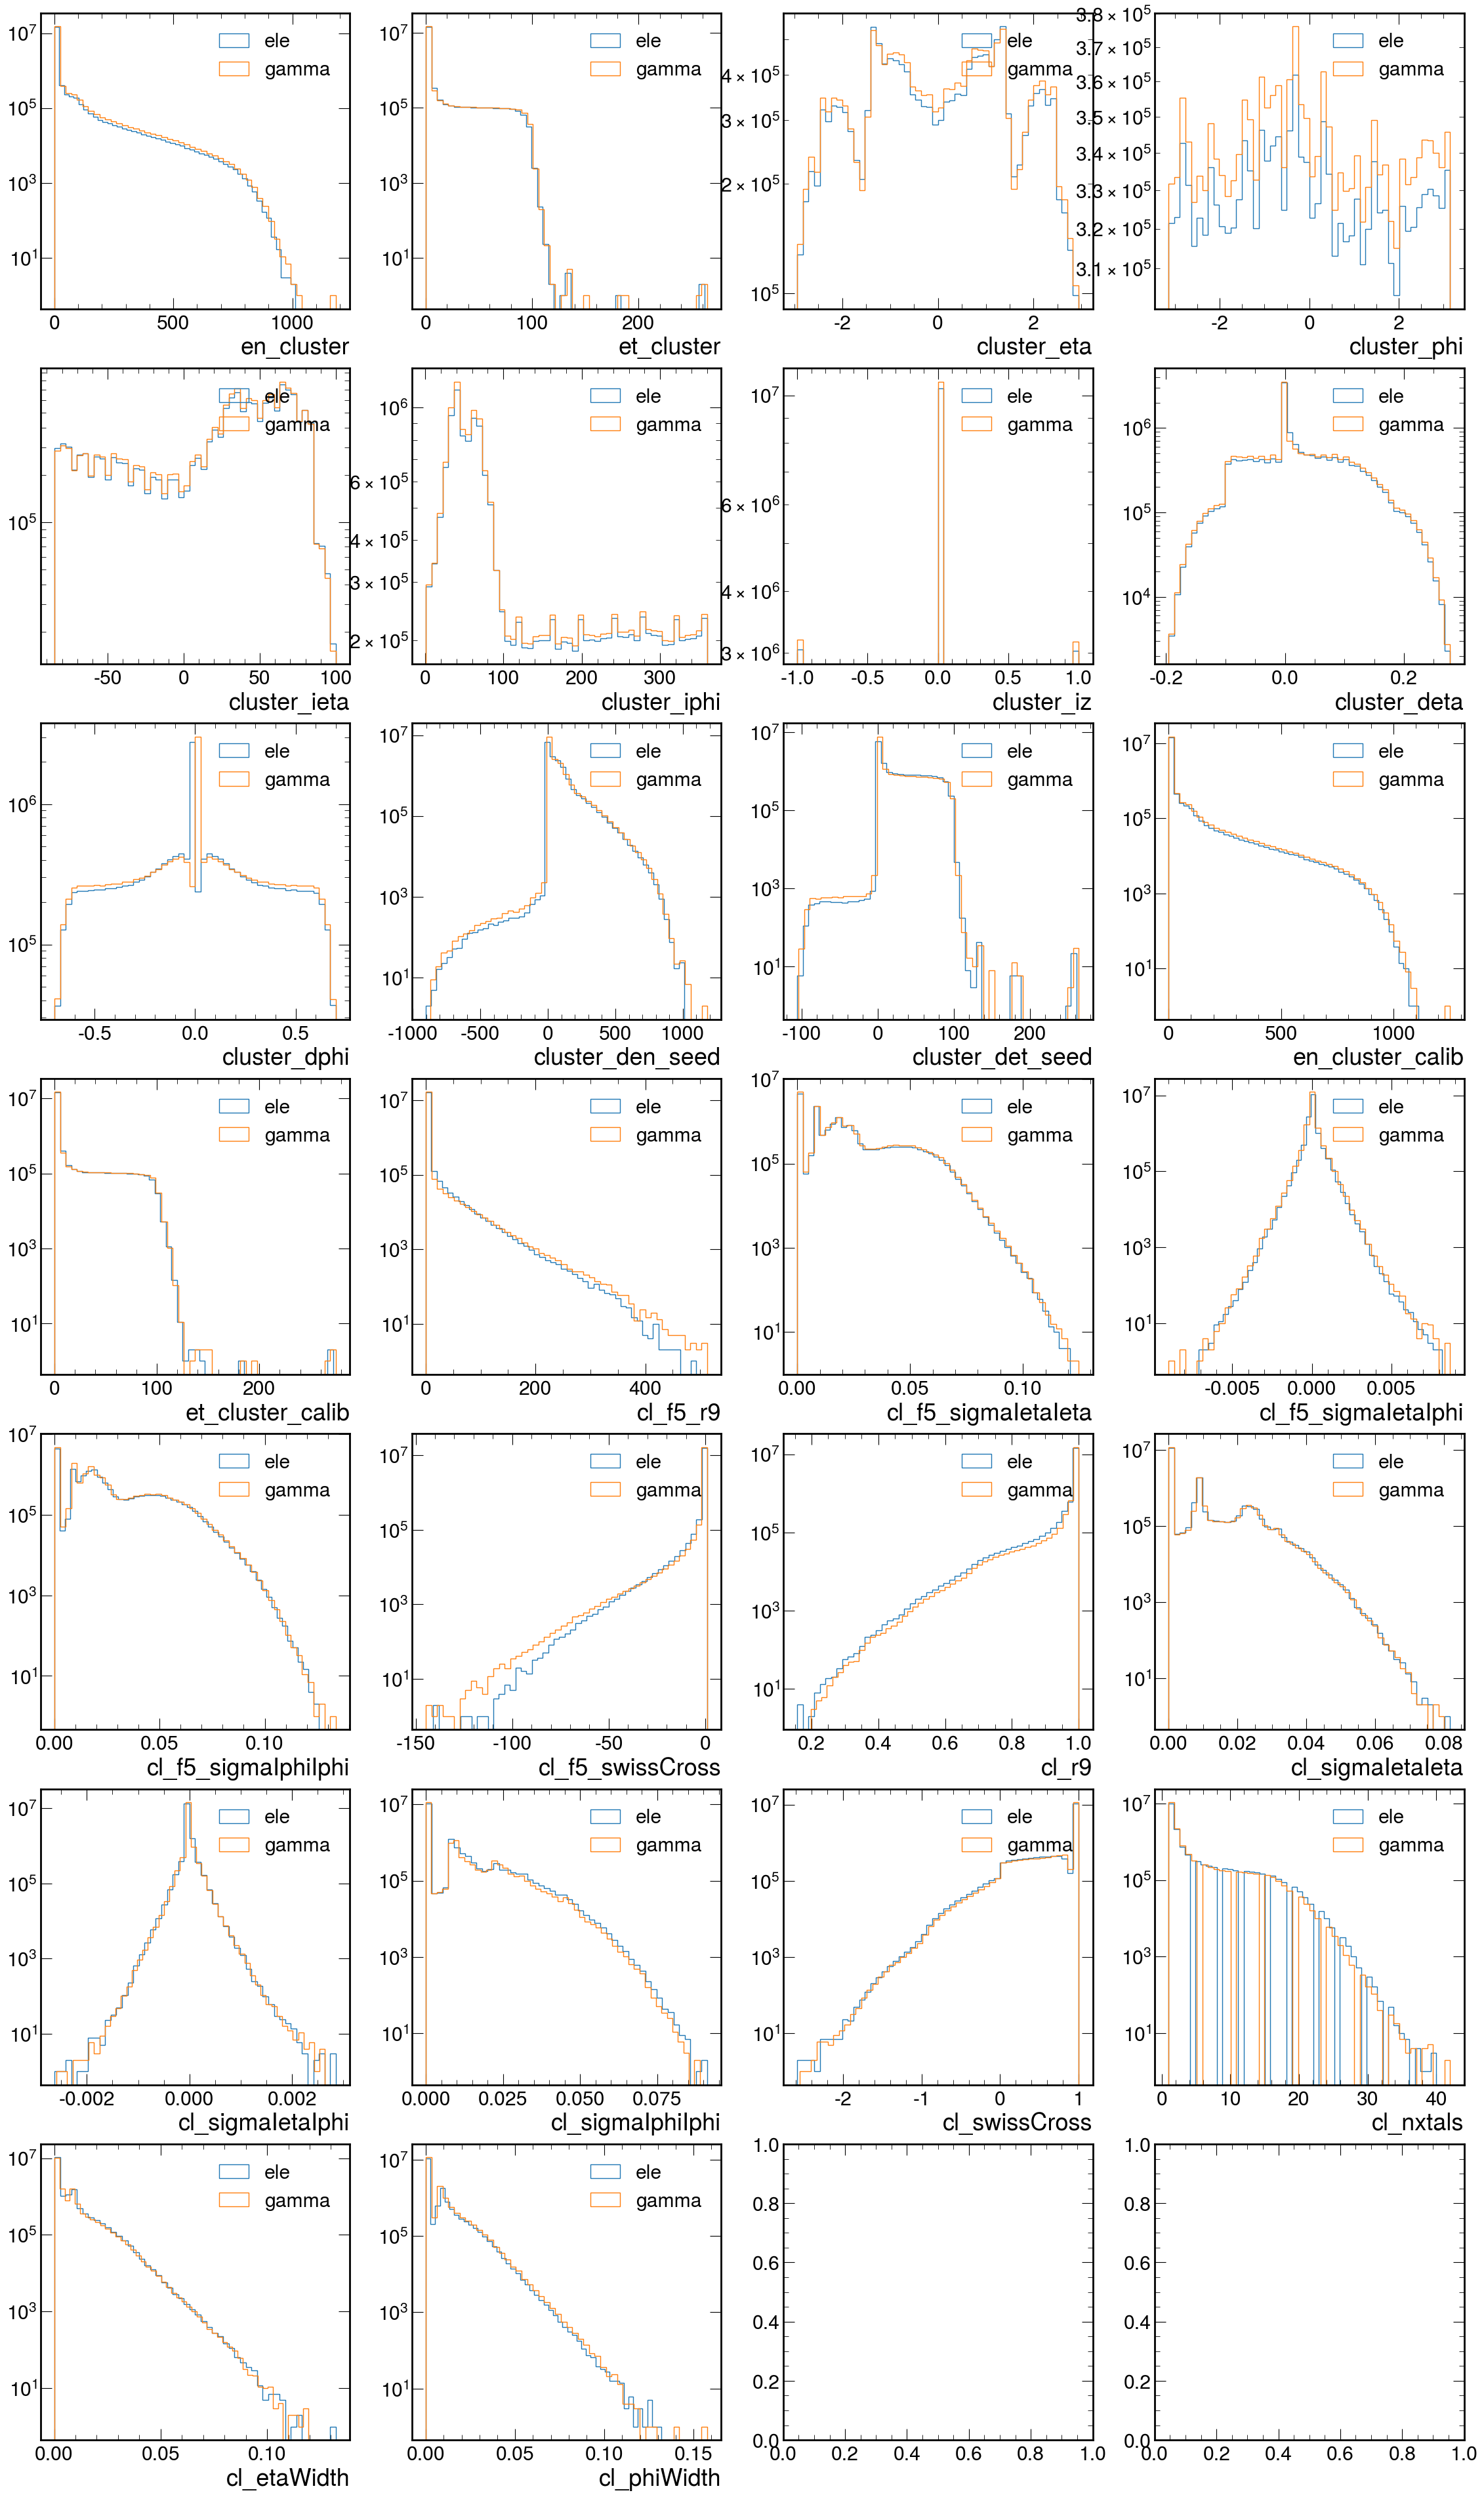

In [22]:
cols = 4
rows = ceil(len(default_features_dict["cl_features"]) / cols)

fig, axs = plt.subplots(rows, cols, figsize=(7*cols, 7*rows))

for iplot, cl_f in enumerate(default_features_dict["cl_features"]):
    ax = axs[iplot//cols][iplot % cols]
    ax.hist(ak.flatten(df_ele.cl_features[cl_f]), bins=50, histtype="step", label="ele")
    ax.hist(ak.flatten(df_gamma.cl_features[cl_f]), bins=50, histtype="step", label="gamma")
    ax.legend()
    ax.set_yscale("log")
    ax.set_xlabel(cl_f)
    

In [6]:
def min_max_scaling(X, cl_f, range=(0,1)):
    mmax = stats[cl_f]["max"]
    mmin = stats[cl_f]["min"]
    X_std = (X - mmin) / (mmax - mmin)
    X_scaled = X_std * (range[1]-range[0]) + range[0]
    return X_scaled

In [30]:
x = np.asarray(ak.flatten(df_ele.cl_features["en_cluster"]))

In [19]:
x

array([(31.88688278, 30.24094016), ( 0.88821614,  0.81460744),
       ( 0.49561632,  0.47515057), ..., ( 1.27645361,  0.35754223),
       ( 1.14193571,  0.30302136), ( 0.81224203,  0.23726097)],
      dtype=[('en_cluster', '<f8'), ('et_cluster', '<f8')])

In [53]:
min_max_scaling(x, "en_cluster")

<Array [0.0268, 0.000557, ... 0.000492] type='16405478 * float64'>

In [26]:
from sklearn.preprocessing import quantile_transform, QuantileTransformer

In [31]:
t = QuantileTransformer(n_quantiles=100) 

In [33]:
t.fit(x.reshape(-1,1))

QuantileTransformer(n_quantiles=100)

In [36]:
q = t.quantiles_

In [42]:
q.flatten()

array([2.30002761e-01, 2.39732019e-01, 2.47537799e-01, 2.54913311e-01,
       2.61805472e-01, 2.68202931e-01, 2.74117762e-01, 2.79980665e-01,
       2.86153896e-01, 2.92332633e-01, 2.98414875e-01, 3.04214209e-01,
       3.10382857e-01, 3.17046003e-01, 3.23661032e-01, 3.30283948e-01,
       3.37662258e-01, 3.44677876e-01, 3.52380685e-01, 3.60840226e-01,
       3.69544406e-01, 3.78405246e-01, 3.87756109e-01, 3.97832960e-01,
       4.08854346e-01, 4.20957384e-01, 4.33595414e-01, 4.47486002e-01,
       4.62658489e-01, 4.78911728e-01, 4.96017497e-01, 5.14594680e-01,
       5.36348468e-01, 5.58735132e-01, 5.84304165e-01, 6.07258493e-01,
       6.26928785e-01, 6.46604197e-01, 6.67938102e-01, 6.89561519e-01,
       7.12389691e-01, 7.37206730e-01, 7.62118833e-01, 7.90258651e-01,
       8.20363939e-01, 8.52504096e-01, 8.82952804e-01, 9.16962445e-01,
       9.54725650e-01, 9.93336174e-01, 1.03494238e+00, 1.07737836e+00,
       1.12240485e+00, 1.16949003e+00, 1.22448994e+00, 1.27835238e+00,
      

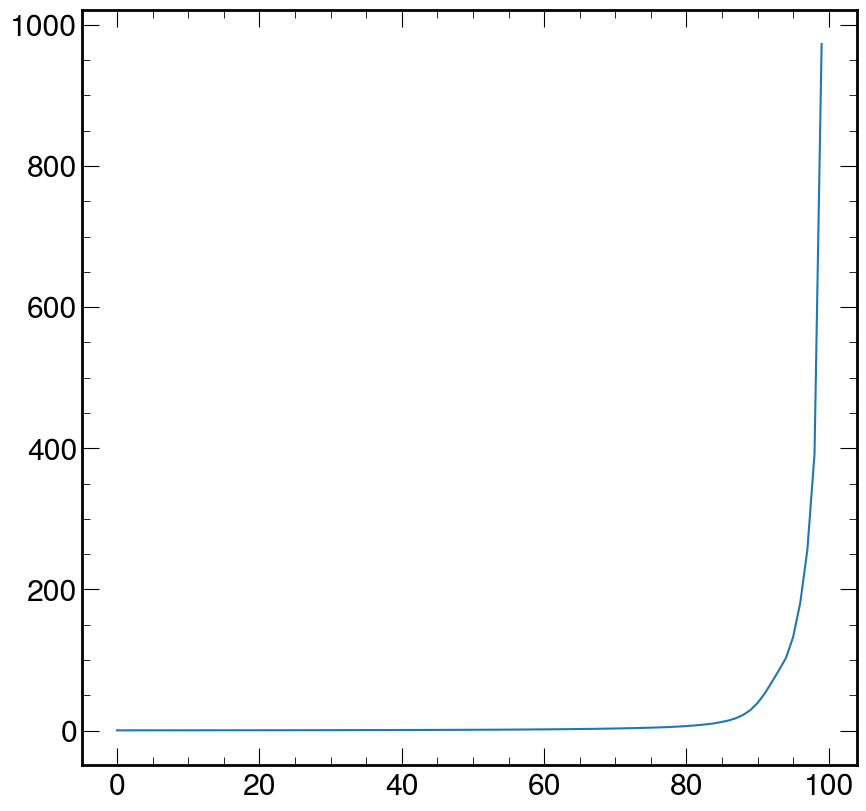

In [41]:
plt.plot(q.flatten())

(array([163297., 161934., 169412., 156919., 161151., 164631., 171723.,
        167784., 162440., 165476., 156704., 152297., 161988., 174229.,
        155195., 161735., 160693., 167787., 159352., 168336., 174375.,
        169166., 168952., 161812., 169709., 167189., 168252., 156602.,
        160297., 170131., 155961., 161530., 166838., 157176., 165558.,
        162388., 167994., 161298., 164504., 160948., 162671., 167222.,
        163190., 157302., 160036., 161617., 163214., 159119., 159041.,
        164633., 166128., 163362., 166997., 173095., 172298., 172459.,
        156265., 166710., 164469., 157312., 156295., 161110., 167115.,
        165093., 160346., 174164., 163104., 164734., 167251., 157554.,
        168140., 166250., 168901., 165294., 164778., 161774., 163557.,
        175264., 166240., 151038., 167691., 161434., 163473., 169109.,
        171264., 171302., 164845., 162098., 161649., 162539., 164798.,
        162638., 159704., 160607., 161188., 165670., 165377., 167260.,
      

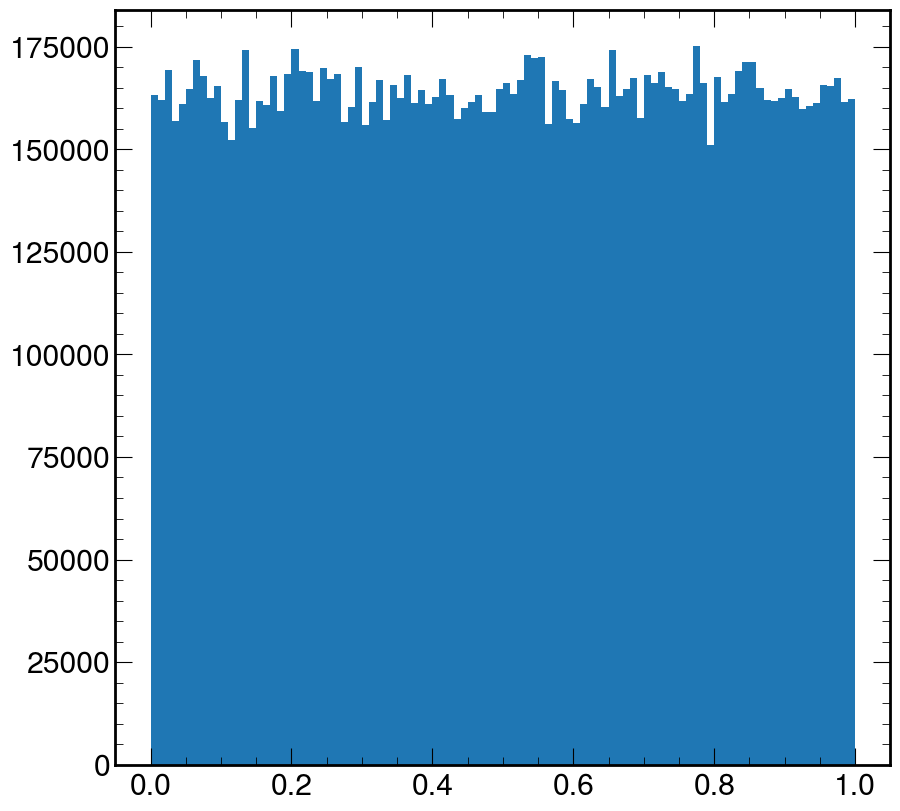

In [24]:
plt.hist(xtr, binsa=100)

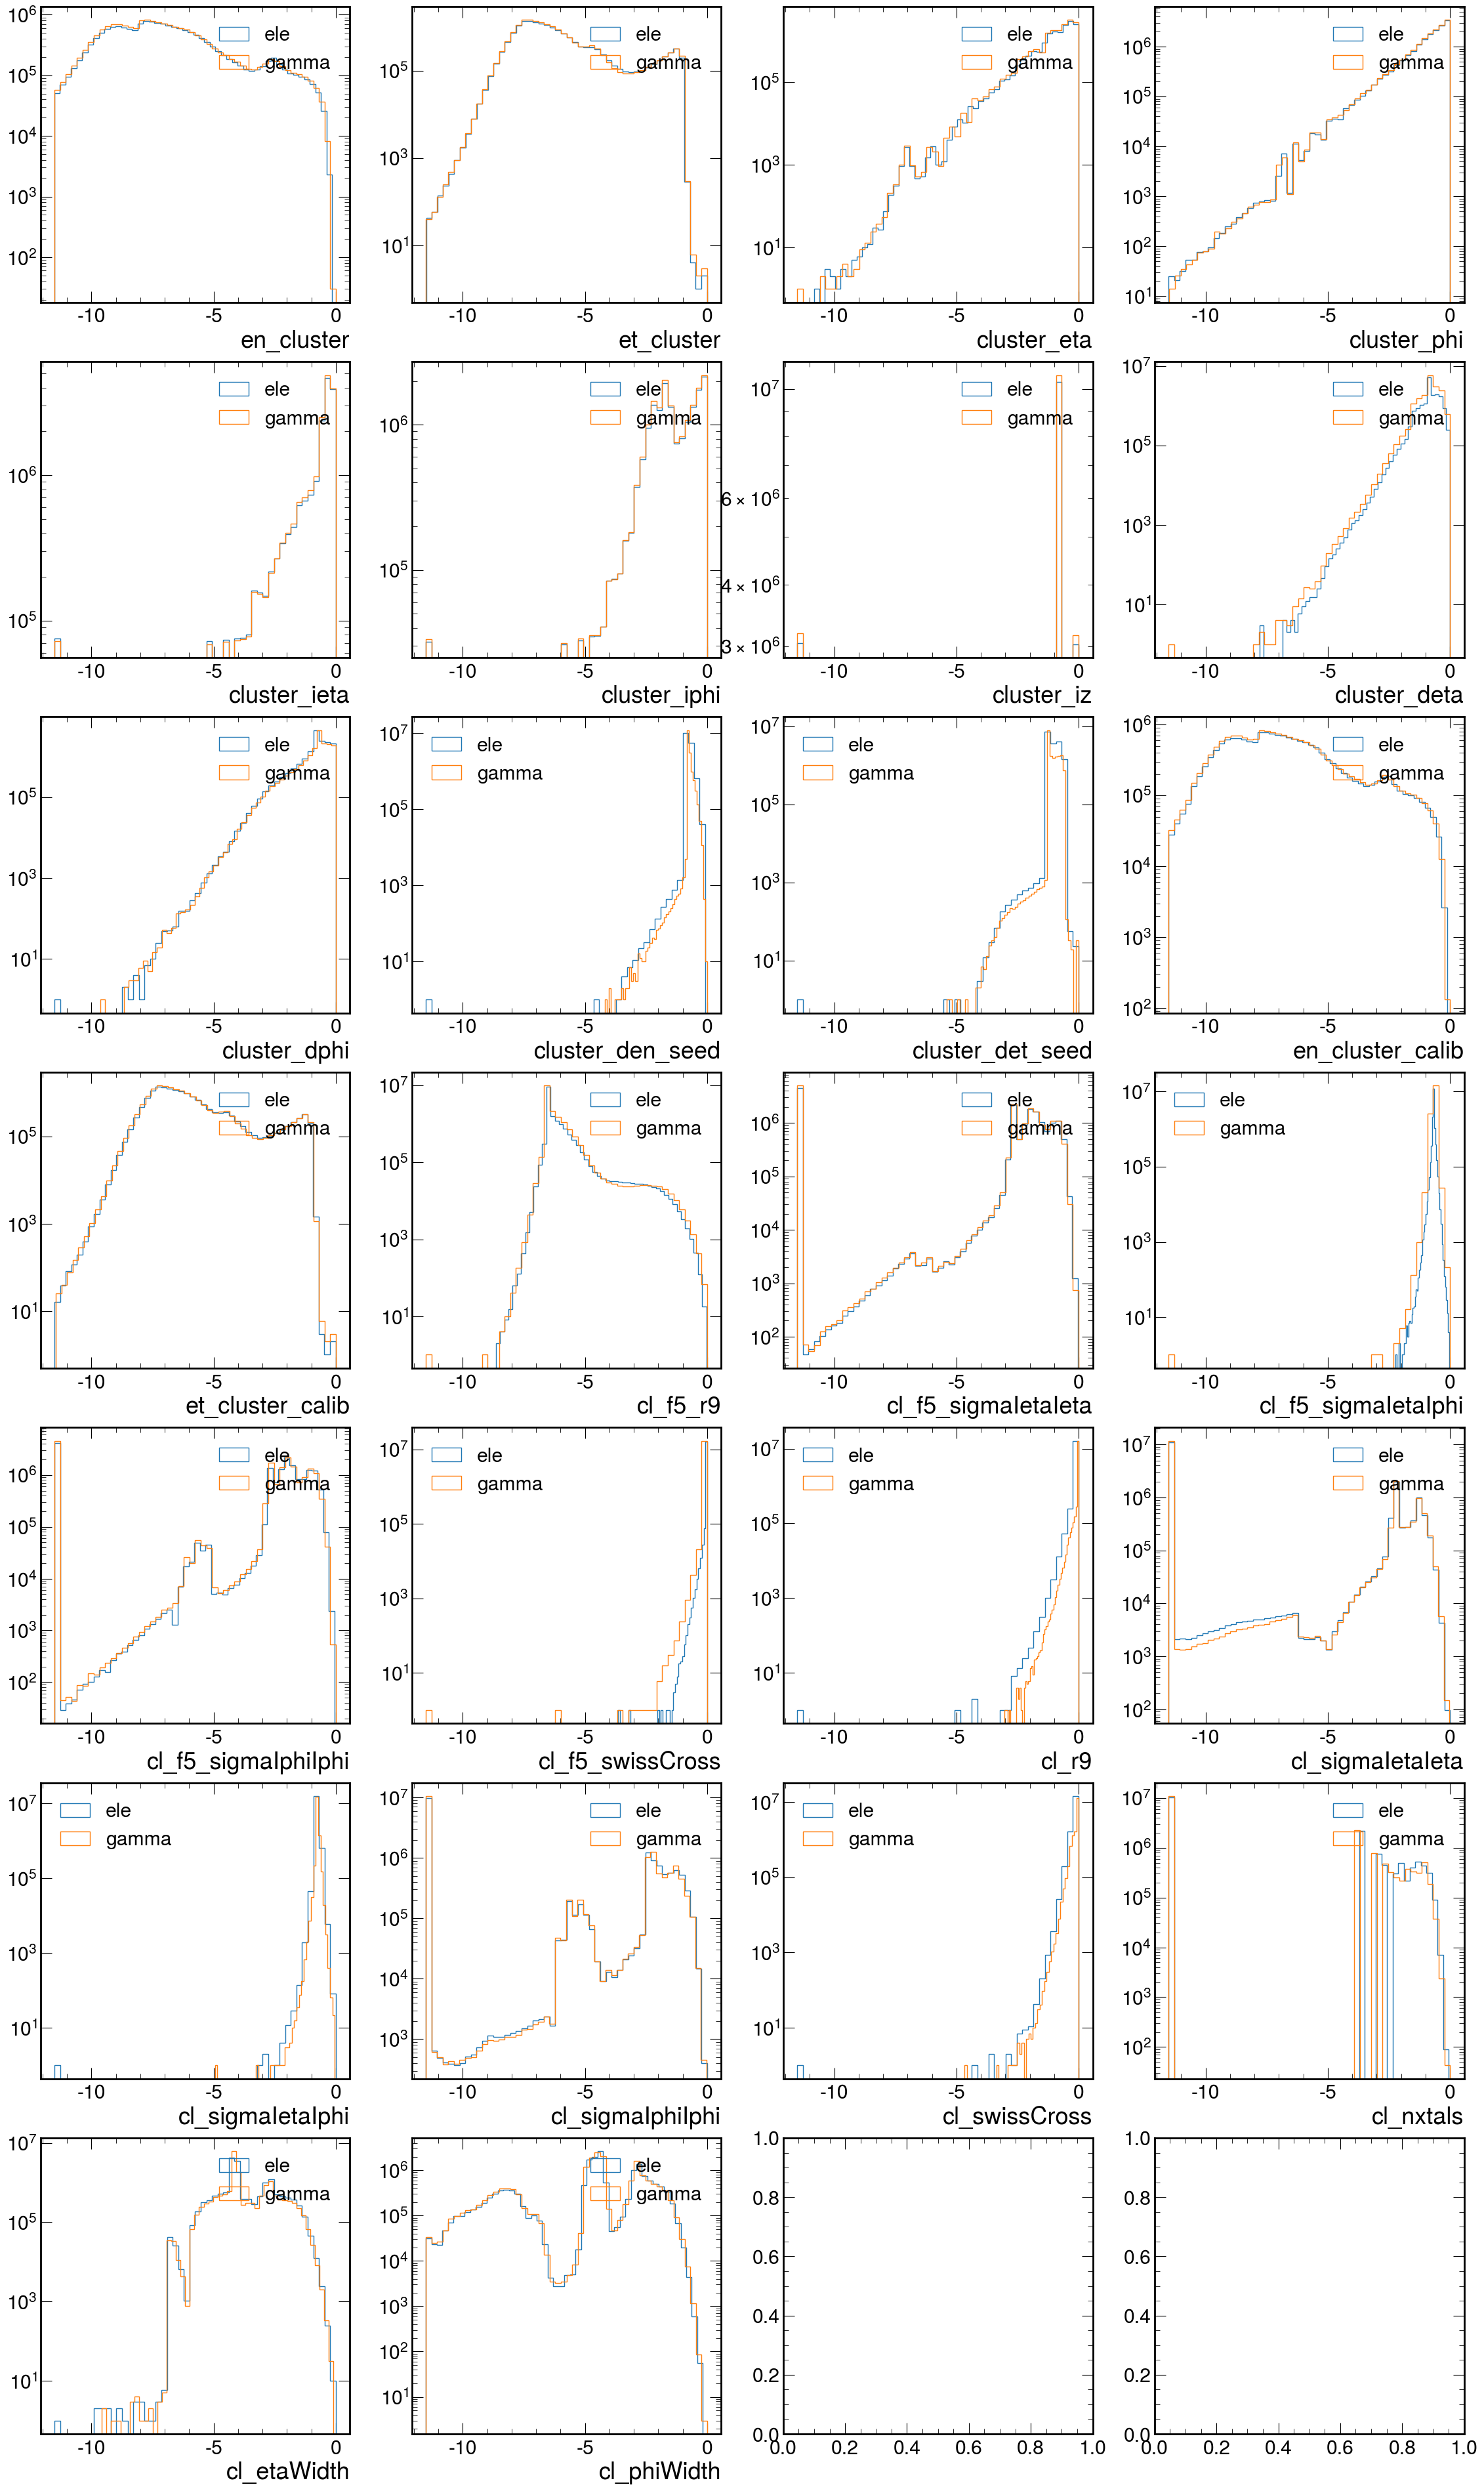

In [56]:
cols = 4
rows = ceil(len(default_features_dict["cl_features"]) / cols)

fig, axs = plt.subplots(rows, cols, figsize=(7*cols, 7*rows))

for iplot, cl_f in enumerate(default_features_dict["cl_features"]):
    ax = axs[iplot//cols][iplot % cols]
    ax.hist(np.log(min_max_scaling(ak.flatten(df_ele.cl_features[cl_f]), cl_f)+ 1e-5), bins=50, histtype="step", label="ele")
    ax.hist(np.log(min_max_scaling(ak.flatten(df_gamma.cl_features[cl_f]), cl_f)+ 1e-5), bins=50, histtype="step", label="gamma")
    ax.legend()
    ax.set_yscale("log")
    ax.set_xlabel(cl_f)

## Log scale transformation

/work/dvalsecc/miniconda3/envs/clustering/lib/python3.10/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(
/work/dvalsecc/miniconda3/envs/clustering/lib/python3.10/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(


ValueError: supplied range of [-inf, 0.0] is not finite

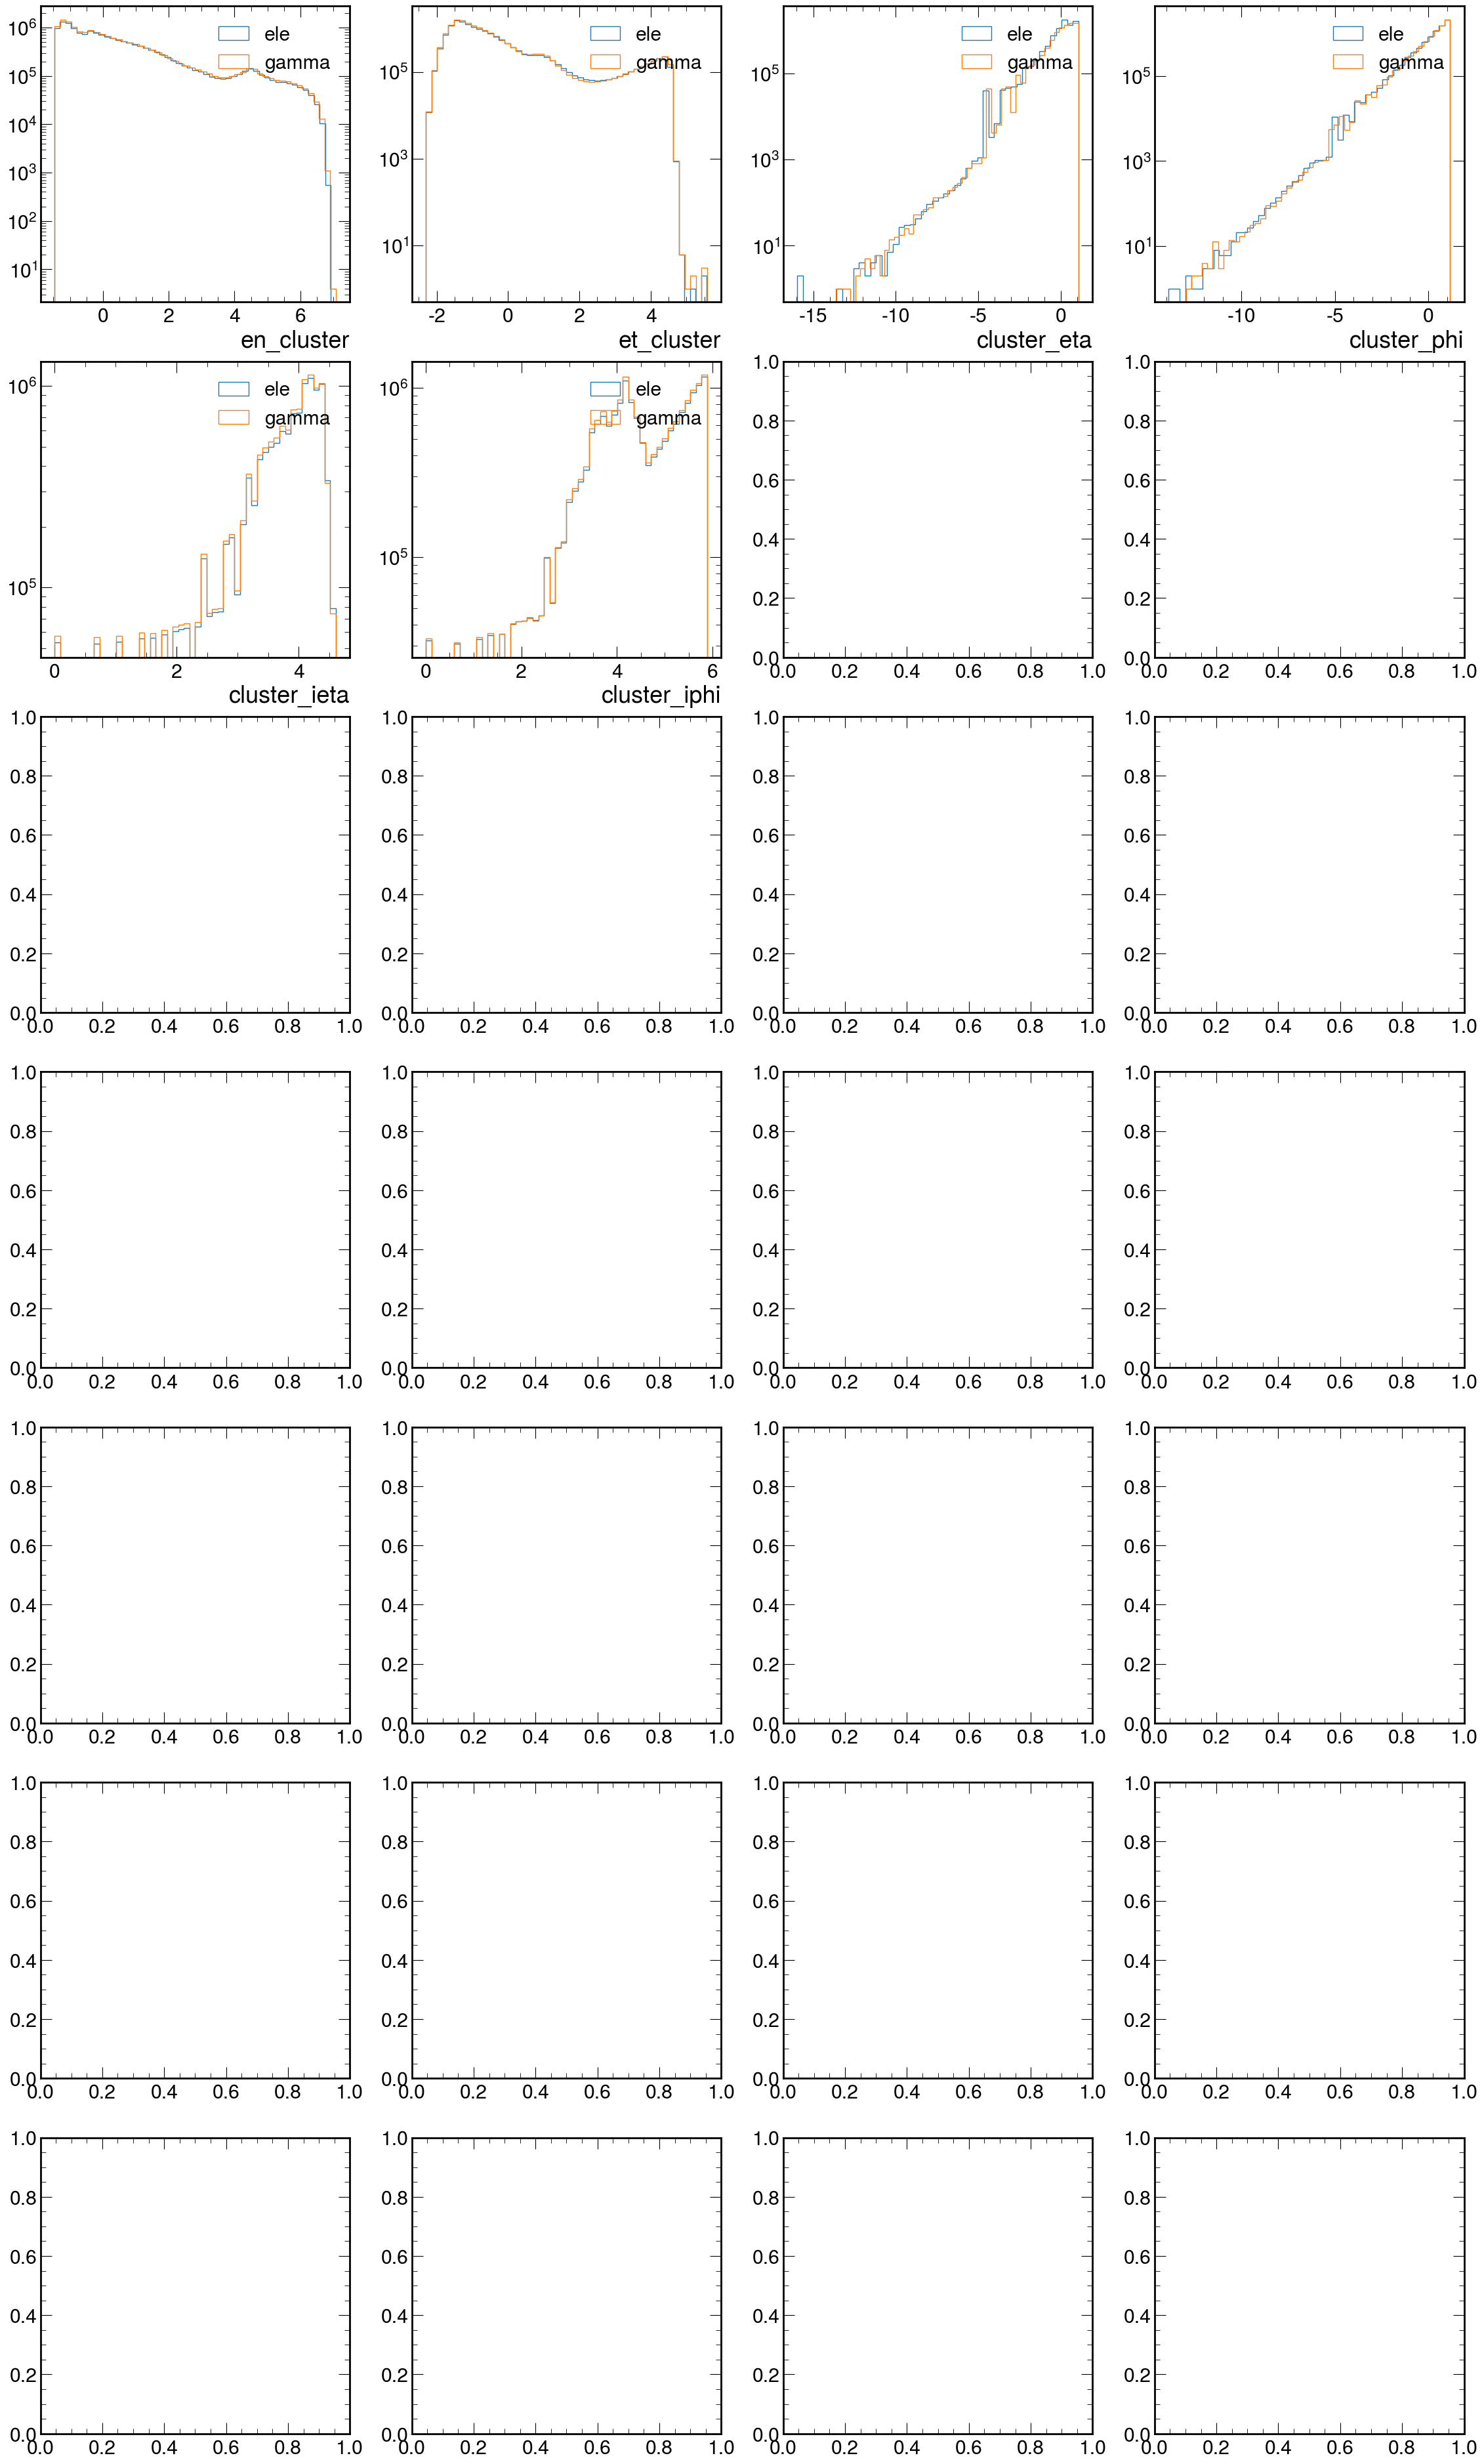

In [44]:
cols = 4
rows = ceil(len(default_features_dict["cl_features"]) / cols)

fig, axs = plt.subplots(rows, cols, figsize=(7*cols, 7*rows))

for iplot, cl_f in enumerate(default_features_dict["cl_features"]):
    ax = axs[iplot//cols][iplot % cols]
    ax.hist(ak.flatten(df_ele.cl_features[cl_f]), bins=50, histtype="step", label="ele")
    ax.hist(ak.flatten(df_gamma.cl_features[cl_f]), bins=50, histtype="step", label="gamma")
    ax.legend()
    ax.set_yscale("log")
    ax.set_xlabel(cl_f)

# Delta Energy seed investigation
Only in some cases the seed has a lower energy than the cluster --> this can happen when the window is not symmetric in dEta, towards the endcap

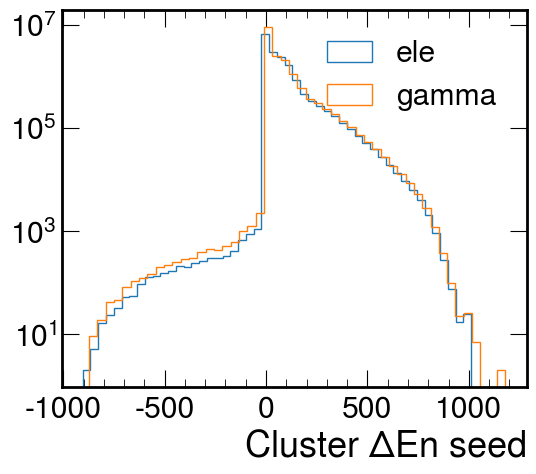

In [25]:
plt.figure(figsize=(6,5))
plt.hist(ak.flatten(df_ele.cl_features.cluster_den_seed), bins=50, histtype="step", label="ele")
plt.hist(ak.flatten(df_gamma.cl_features.cluster_den_seed), bins=50,  histtype="step", label="gamma")
plt.yscale("log")
plt.xlabel("Cluster $\Delta En$ seed")
plt.legend()

In [27]:
mask = df.cl_features.cluster_den_seed < 0 

Text(1, 0, 'Cluster $\\eta$')

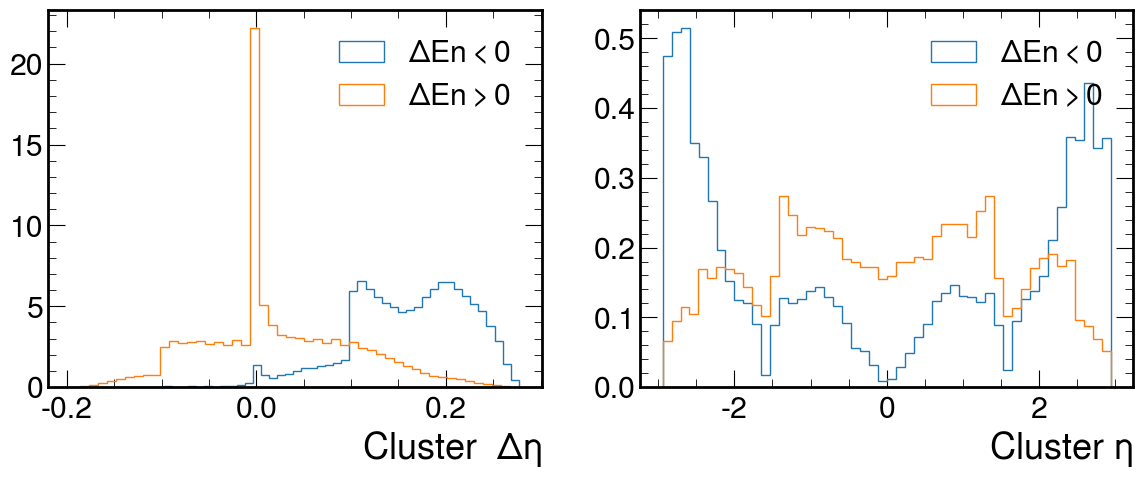

In [43]:
fig, axs = plt.subplots(1, 2, figsize=(14,5))
axs[0].hist(ak.flatten(df.cl_features.cluster_deta[mask]), bins=50, histtype="step", label="$\Delta En < 0$", density=True)
axs[0].hist(ak.flatten(df.cl_features.cluster_deta[~mask]), bins=50, histtype="step", label="$\Delta En > 0$", density=True)
axs[0].legend()
axs[0].set_xlabel("Cluster  $\Delta \eta$")

axs[1].hist(ak.flatten(df.cl_features.cluster_eta[mask]), bins=50, histtype="step", label="$\Delta En < 0$", density=True)
axs[1].hist(ak.flatten(df.cl_features.cluster_eta[~mask]), bins=50, histtype="step", label="$\Delta En > 0$", density=True)
axs[1].legend()
axs[1].set_xlabel("Cluster $\eta$")